In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from io import StringIO
from glob import glob
import wandb
import os
import molgrid
from argparse import Namespace
import torch
from scipy.stats import pearsonr
%matplotlib inline

In [52]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
%matplotlib inline

In [53]:
pub_api = wandb.apis.public.Api()

In [97]:
def get_stats(epoch, pred_ddg, actual_ddg, pred_abs, actual_abs):
    try:
        r_ddg, _ = pearsonr(np.array(actual_ddg), np.array(pred_ddg))
    except ValueError as e:
        print('{}:{}'.format(epoch, e))
        r_ddg = np.nan
    try:
        r_abs, _ = pearsonr(np.array(pred_abs), np.array(actual_abs))
    except ValueError as e:
        print(f'{epoch}:{e}')
        r_abs = np.nan
    r = (r_ddg, r_abs)

    rmse_ddg = np.sqrt(((np.array(pred_ddg)-np.array(actual_ddg)) ** 2).mean())
    rmse_abs = np.sqrt(((np.array(pred_abs)-np.array(actual_abs)) ** 2).mean())
    rmse = (rmse_ddg, rmse_abs)

    mae = (np.abs(np.array(pred_ddg)-np.array(actual_ddg)).mean(),
            np.abs(np.array(pred_abs)-np.array(actual_abs)).mean())
    return r, rmse, mae

def get_eval(args,model_file,return_vals=False):
    if args.use_model == "multtask_latent_def2018":
        from python_files.multtask_latent_def2018_model import Net
    elif args.use_model == "multtask_latent_dense":
        from python_files.multtask_latent_dense_model import Dense as Net
    elif args.use_model == "multtask_latent_def2018_concat":
        from python_files.multtask_latent_def2018_concat_model import Net
    elif args.use_model == "def2018":
        return get_eval_nosiam(args,model_file)
    test_data = molgrid.ExampleProvider(ligmolcache=f"cache/{args.ligte.split('/')[-1]}",
                                        recmolcache=f"cache/{args.recte.split('/')[-1]}", 
                                    shuffle=True, duplicate_first=True, default_batch_size=16,
                                    iteration_scheme=molgrid.IterationScheme.LargeEpoch)
    addnl_directory=''
    if 'pfam' in args.testfile:
        addnl_directory='PFAM_CV/'
    test_data.populate(f"new_Prot_Lig_Valid/{addnl_directory}{args.testfile.split('/')[-1]}")
    
    gmaker = molgrid.GridMaker(binary=args.binary_rep)      
    dims = gmaker.grid_dimensions(14*4)  # only one rec+onelig per example      
    tensor_shape = (16,)+dims      

    actual_dims = (dims[0]//2, *dims[1:])      
    model = Net(actual_dims,args).to('cuda')
    
    pretrained_state_dict = torch.load(model_file)      
    model_dict = model.state_dict()      
    pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}      
    model_dict.update(pretrained_dict)      
    model.load_state_dict(model_dict) 
    
    if "latent" in args.use_model:
        latent_rep = True
    else:
        latent_rep = False
        
    input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
    float_labels = torch.zeros(16, dtype=torch.float32)
    lig1_label = torch.zeros(16, dtype=torch.float32)
    lig2_label = torch.zeros(16, dtype=torch.float32)
    
    #running test loop
    model.eval()

    output_dist, actual = [], []
    lig_pred, lig_labels = [], []
    with torch.no_grad():
        for idx, batch in enumerate(test_data):        
            gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
            batch.extract_label(1, float_labels)
            labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
            batch.extract_label(2, lig1_label)
            batch.extract_label(3, lig2_label)
            lig1_labels = torch.unsqueeze(lig1_label, 1).float().to('cuda')
            lig2_labels = torch.unsqueeze(lig2_label, 1).float().to('cuda')
            if latent_rep:
                output, lig1, lig2, lig1_rep1, lig2_rep1 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
#                 if proj:
#                     lig1_rep1 = proj(lig1_rep1)
#                     lig1_rep2 = proj(lig1_rep2)
#                     lig2_rep1 = proj(lig2_rep1)
#                     lig2_rep2 = proj(lig2_rep2)
            else:
                output, lig1, lig2 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
            lig_pred += lig1.flatten().tolist() + lig2.flatten().tolist()
            lig_labels += lig1_labels.flatten().tolist() + lig2_labels.flatten().tolist()
            output_dist += output.flatten().tolist()
            actual += labels.flatten().tolist()
            
    r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
    if return_vals == False:
        return r, rmse, mae
    else:
        return r, rmse, mae, (output_dist,actual)
def get_eval_nosiam(args,model_file):
#     if args.use_model == "def2018":
    from python_files.default2018_single_model import Net
    
    test_data = molgrid.ExampleProvider(ligmolcache=f"cache/{args.ligte.split('/')[-1]}",
                                        recmolcache=f"cache/{args.recte.split('/')[-1]}", 
                                    shuffle=True, duplicate_first=True, default_batch_size=16,
                                    iteration_scheme=molgrid.IterationScheme.LargeEpoch)      
    test_data.populate(f"new_Prot_Lig_Valid/{args.testfile.split('/')[-1]}")
    
    gmaker = molgrid.GridMaker(binary=args.binary_rep)      
    dims = gmaker.grid_dimensions(14*4)  # only one rec+onelig per example      
    tensor_shape = (16,)+dims      

    actual_dims = (dims[0]//2, *dims[1:])      
    model = Net(actual_dims,args).to('cuda')
    
    pretrained_state_dict = torch.load(model_file)      
    model_dict = model.state_dict()      
    pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}      
    model_dict.update(pretrained_dict)      
    model.load_state_dict(model_dict) 
        
    input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
    float_labels = torch.zeros(16, dtype=torch.float32)
    lig1_label = torch.zeros(16, dtype=torch.float32)
    lig2_label = torch.zeros(16, dtype=torch.float32)
    
    #running test loop
    model.eval()

    output_dist, actual = [], []
    lig_pred, lig_labels = [], []
    with torch.no_grad():
        for idx, batch in enumerate(test_data):        
            gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
            batch.extract_label(1, float_labels)
            labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
            batch.extract_label(2, lig1_label)
            batch.extract_label(3, lig2_label)
            lig1_labels = torch.unsqueeze(lig1_label, 1).float().to('cuda')
            lig2_labels = torch.unsqueeze(lig2_label, 1).float().to('cuda')
            lig1 = model(input_tensor_1[:, :28, :, :, :])
            lig2 = model(input_tensor_1[:, 28:, :, :, :])
            lig_pred += lig1.flatten().tolist() + lig2.flatten().tolist()
            lig_labels += lig1_labels.flatten().tolist() + lig2_labels.flatten().tolist()
            output_dist += (lig1-lig2).flatten().tolist()
            actual += labels.flatten().tolist()
            
    r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
    return r, rmse, mae

def get_eval_external(args,model_file,return_vals=False):
    if args.use_model == "multtask_latent_def2018":
        from python_files.multtask_latent_def2018_model import Net
    elif args.use_model == "multtask_latent_dense":
        from python_files.multtask_latent_dense_model import Dense as Net
    elif args.use_model == "multtask_latent_def2018_concat":
        from python_files.multtask_latent_def2018_concat_model import Net
    elif args.use_model == "def2018":
        return get_eval_nosiam(args,model_file)
    
    gmaker = molgrid.GridMaker(binary=args.binary_rep)      
    dims = gmaker.grid_dimensions(14*4)  # only one rec+onelig per example      
    tensor_shape = (16,)+dims      

    actual_dims = (dims[0]//2, *dims[1:])      
    model = Net(actual_dims,args).to('cuda')
    
    pretrained_state_dict = torch.load(model_file)      
    model_dict = model.state_dict()      
    pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}      
    model_dict.update(pretrained_dict)      
    model.load_state_dict(model_dict) 
    
    if "latent" in args.use_model:
        latent_rep = True
    else:
        latent_rep = False
        
    input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
    float_labels = torch.zeros(16, dtype=torch.float32)
    lig1_label = torch.zeros(16, dtype=torch.float32)
    lig2_label = torch.zeros(16, dtype=torch.float32)
    
    external_sets_results= {'PearsonR':dict(),'RMSE':dict(),'MAE':dict(),'Abs_PearsonR':dict(),'Abs_RMSE':dict(),'Abs_MAE':dict()}
    for external_set in sorted(glob('external_test/*/')):
        if 'Inputs_for_FEP' in external_set:
            continue
        test_data = molgrid.ExampleProvider(ligmolcache=f"cache/lig_{external_test.split('/')[-2]}.molcache2",
                                            recmolcache=f"cache/rec_{external_test.split('/')[-2]}.molcache2", 
                                        shuffle=True, duplicate_first=True, default_batch_size=16,
                                        iteration_scheme=molgrid.IterationScheme.LargeEpoch)
        test_data.populate(f"{external_test}{external_test.split('/')[-2]}_DDG.types")

        #running test loop
        model.eval()

        output_dist, actual = [], []
        lig_pred, lig_labels = [], []
        with torch.no_grad():
            for idx, batch in enumerate(test_data):        
                gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
                batch.extract_label(1, float_labels)
                labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
                batch.extract_label(2, lig1_label)
                batch.extract_label(3, lig2_label)
                lig1_labels = torch.unsqueeze(lig1_label, 1).float().to('cuda')
                lig2_labels = torch.unsqueeze(lig2_label, 1).float().to('cuda')
                if latent_rep:
                    output, lig1, lig2, lig1_rep1, lig2_rep1 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
    #                 if proj:
    #                     lig1_rep1 = proj(lig1_rep1)
    #                     lig1_rep2 = proj(lig1_rep2)
    #                     lig2_rep1 = proj(lig2_rep1)
    #                     lig2_rep2 = proj(lig2_rep2)
                else:
                    output, lig1, lig2 = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
                lig_pred += lig1.flatten().tolist() + lig2.flatten().tolist()
                lig_labels += lig1_labels.flatten().tolist() + lig2_labels.flatten().tolist()
                output_dist += output.flatten().tolist()
                actual += labels.flatten().tolist()

        r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
        external_sets_results['PearsonR'][f"{external_set.split('/')[-2]}"] = r[0]
        external_sets_results['RMSE'][f"{external_set.split('/')[-2]}"] = rmse[0]
        external_sets_results['MAE'][f"{external_set.split('/')[-2]}"] = mae[0]
        external_sets_results['Abs_PearsonR'][f"{external_set.split('/')[-2]}"] = r[1]
        external_sets_results['Abs_RMSE'][f"{external_set.split('/')[-2]}"] = rmse[1]
        external_sets_results['Abs_MAE'][f"{external_set.split('/')[-2]}"] = mae[1]
        
    return (external_sets_results['PearsonR'],external_sets_results['Abs_PearsonR']), (external_sets_results['RMSE'],external_sets_results['Abs_RMSE']),(external_sets_results['MAE'],external_sets_results['Abs_MAE'])

In [99]:
def create_stats(model_save_path,num_runs = 25,model="multtask_latent_def2018",
                 num_addnl=1,weight_decay=0,ddg_weight=10,consistency_weight=1,
                absolute_weight=1,rotation_weight=1,use_weights=None,spec_name='',
                 rot_warmup=0,state="finished",tag='MseLoss',):
    runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},
                                        {'tags':f'addnl_ligs_{num_addnl}' if num_addnl else 'TrainAllPerms'},
                                        {"config.rot_warmup":rot_warmup},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},{"tags":tag},
                                        {"state":state}]})
    assert len(runs) == num_runs, f"only have {len(runs)} runs"
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    rands = []
    stats_list = []
    for idx, run in enumerate(runs):
        if num_addnl:
            rand = run.config['trainfile'].split('_')[-3]
            assert "rand" in rand, f"{randval}, doesn't have 'rand' in it"
            randval = int(rand.replace('rand',''))
        else:
            randval = idx
        rands.append(randval)

        if not os.path.isfile(f"{model_save_path}model{spec_name}_{num_addnl}_{randval}.h5"):
            run.file('model.h5').download(root=model_save_path)
            os.rename(f"{model_save_path}model.h5",f"{model_save_path}model{spec_name}_{num_addnl}_{randval}.h5")

        config = Namespace()
        for k,v in run.config.items():
            setattr(config,k,v)
        
        if 'all_newdata.types' in config.trainfile:
            r,rmse, mae = get_eval_external(config,f"{model_save_path}model{spec_name}_{num_addnl}_{randval}.h5")
            stats_list.append([randval] + list(r[0].values()) + list(rmse[0].values())
                              + list(mae[0].values()) + list(r[1].values())
                              + list(rmse[1].values()) + list(mae[1].values()))
        else:
            r,rmse, mae = get_eval(config,f"{model_save_path}model{spec_name}_{num_addnl}_{randval}.h5")
            stats_list.append([randval,r[0],rmse[0],mae[0],r[1],rmse[1],mae[1]])
        print(spec_name,randval,r,rmse,mae)
        
    if 'all_newdata.types' in config.trainfile:
        final_stats = pd.DataFrame(stats_list, columns = ['randval'] + [f"{meas}_{ext_set.split('/')[-2]}" for meas in ['PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE'] for ext_set in sorted(glob('external_test/*/')) if 'Input' not in ext_set])
    else:
        final_stats = pd.DataFrame(stats_list,columns=['randval','PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE'])
    if num_addnl:
        final_stats.to_csv(f"{model_save_path}statistics{spec_name}_{num_addnl}.csv",index=False,float_format="%.4f")
    else:
        final_stats.to_csv(f"{model_save_path}statistics{spec_name}.csv",index=False,float_format="%.4f")
    return final_stats

In [56]:
base_statistics = ['PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE']
avg_std_base_statistics = [f'Avg_{base}' for base in base_statistics] + [f'Std_{base}' for base in base_statistics]
def build_graph(list_csvs):
    stats_list = []
    for csv in list_csvs:
        data = pd.read_csv(csv)
        avgs = data[base_statistics].mean(axis=0)
        stds = data[base_statistics].std(axis=0)
        stats_list.append([csv] + avgs.values.tolist()+stds.values.tolist())
#     print(stats_list)
    return pd.DataFrame(stats_list,columns=['CSV_name']+avg_std_base_statistics)

In [10]:
#Additional Ligands w/ Def2018
# for val in range(1,7):
# #     create_stats('models/addnl_ligs/def2018/',num_addnl=val)
#Additional Ligands w/ Dense
# for val in range(1,6):
#     create_stats('models/addnl_ligs/dense/',model='multtask_latent_dense',num_runs=5,num_addnl=val,use_weights='gnina_weights/dense_model.pt',weight_decay=0.01)
    
#Ablation Study
# create_stats('models/ablation/',spec_name='_combo',tag='combo')
# create_stats('models/ablation/',model='multtask_latent_def2018_concat',spec_name='_ConcatCombo',tag='combo',num_runs=20)
# create_stats('models/ablation/',ddg_weight=0,spec_name='_noDDG')
# create_stats('models/ablation/',absolute_weight=0,spec_name='_noDG') #wait until rerun rand12
# create_stats('models/ablation/',rotation_weight=0,spec_name='_noRot')
# create_stats('models/ablation/',consistency_weight=0,spec_name='_noCons')
# create_stats('models/ablation/',consistency_weight=0,ddg_weight=0,spec_name='_noDDG_noCons')
# create_stats('models/ablation/',consistency_weight=0,absolute_weight=0,spec_name='_noDG_noCons')
# create_stats('models/ablation/',model='multtask_latent_def2018_concat',spec_name='_Concat')
# create_stats('models/ablation/',model='def2018',consistency_weight=None,rot_warmup=None,ddg_weight=1,spec_name='_NoSiam')

27648
_combo 24 (0.4929032657448492, 0.8277421180411411) (1.1899100497253532, 0.9299938903678671) (0.889188956212378, 0.668318109650569)
27648
_combo 23 (0.49701571476380174, 0.8383999830196522) (1.1999731610642126, 0.9116838699854309) (0.8852781301413234, 0.6421011441419391)
27648
_combo 22 (0.5277520905349793, 0.8433525365184704) (1.1653072628730756, 0.8928559274900669) (0.8619048015648293, 0.6264183047774756)
27648
_combo 21 (0.5139300460441294, 0.8275052104752889) (1.1644470547359644, 0.9262080423300707) (0.869653896449692, 0.6735511599481795)
27648
_combo 20 (0.5214259066352132, 0.8352092628694486) (1.1872515085021524, 0.93004079730056) (0.8964221556345003, 0.6761860363082053)
27648
_combo 5 (0.5288799910755849, 0.8349472419154804) (1.1506109634385597, 0.9108754350241512) (0.866672939753252, 0.6708695513429407)
27648
_combo 3 (0.5328016494603691, 0.841705441114776) (1.1425580786611536, 0.8925698126124005) (0.848404239546227, 0.6389804963014145)
27648
_combo 4 (0.5002682634875587, 

,randval,PearsonR,RMSE,MAE,Abs_PearsonR,Abs_RMSE,Abs_MAE
0,24,0.492903,1.189910,0.889189,0.827742,0.929994,0.668318
1,23,0.497016,1.199973,0.885278,0.838400,0.911684,0.642101
2,22,0.527752,1.165307,0.861905,0.843353,0.892856,0.626418
3,21,0.513930,1.164447,0.869654,0.827505,0.926208,0.673551
4,20,0.521426,1.187252,0.896422,0.835209,0.930041,0.676186
5,5,0.528880,1.150611,0.866673,0.834947,0.910875,0.670870
6,3,0.532802,1.142558,0.848404,0.841705,0.892570,0.638980
7,4,0.500268,1.168151,0.858181,0.848442,0.900192,0.637090
8,8,0.541193,1.141872,0.862036,0.846081,0.885731,0.632129
9,6,0.550992,1.158042,0.872064,0.837815,0.908381,0.658420


In [14]:
val=6
create_stats('models/addnl_ligs/dense/',model='multtask_latent_dense',num_runs=4,num_addnl=val,use_weights='gnina_weights/dense_model.pt',weight_decay=0.01,state="finished")
create_stats('models/addnl_ligs/dense/',model='multtask_latent_dense',num_runs=1,num_addnl=val,use_weights='gnina_weights/dense_model.pt',weight_decay=0.01,state="crashed",spec_name='_crashed')

 0 (0.797301121578084, 0.9394913037012691) (0.7333424739664773, 0.54225771192357) (0.5206106755521548, 0.3371430662270187)
 2 (0.8026082998302855, 0.9380342631258889) (0.7306361659400236, 0.5460698851432242) (0.5204654101762105, 0.3417630724149759)
 3 (0.7972912250753705, 0.9374682750871566) (0.7435757729037537, 0.550157251416609) (0.5267931086926444, 0.3417002515291192)
 1 (0.7794472788747584, 0.932709594450509) (0.7629489225888794, 0.5698145669025972) (0.5408972640303905, 0.35479992721117987)
_crashed 4 (0.7931515722757645, 0.9375586396913114) (0.7407925976831223, 0.5491058167518261) (0.5250931833640813, 0.3435349665327268)


,randval,PearsonR,RMSE,MAE,Abs_PearsonR,Abs_RMSE,Abs_MAE
0,4,0.793152,0.740793,0.525093,0.937559,0.549106,0.343535


In [8]:
#just dealing with the crashed run, will replace with actually finished run when done training
bad_6 = pd.read_csv('models/addnl_ligs/dense/statistics_crashed_6.csv')
good_6 = pd.read_csv('models/addnl_ligs/dense/statistics_6.csv')
current_6 = good_6.append(bad_6)
current_6.to_csv('models/addnl_ligs/dense/statistics_6_1bad.csv')

# Additional Ligands Evaluation 

In [9]:
addnl_ligs_def2018 = build_graph([f'models/addnl_ligs/def2018/statistics_{val}.csv' for val in range(1,7)])
addnl_ligs_dense = build_graph([f'models/addnl_ligs/dense/statistics_{val}.csv' for val in range(1,6)]+['models/addnl_ligs/dense/statistics_6_1bad.csv'])
addnl_ligs_dense['CSV_name'] = addnl_ligs_dense['CSV_name'].apply(lambda x: x.replace('_1bad',''))

In [10]:
# Values pulled from their graphs with WebPlotDigitizer
their_data = """1 | 0.512 (0.434,0.593) | 1.18 (1.137,1.220)
2 | 0.604(0.589,0.620) |1.10(1.044,1.153)
3 | 0.624(0.617,0.632)|1.06(1.015,1.103)
4 | 0.602(0.520,0.684)|1.045(0.988,1.101)
5 | 0.623(0.614,0.636)|1.03(0.960,1.107)
6 | 0.636(0.628,0.647)|1.042(0.937,1.147)"""
their_data = their_data.replace(' ','').replace('|',',').replace('(',',').replace(')',',').replace(',,',',')
their_df = pd.read_csv(StringIO(their_data),sep=',',header=None)
their_df.columns = ['Addnl Ligs','R','R_stdl','R_stdg','RMSE','RMSE_stdl','RMSE_stdg','bad']
del their_df['bad']
their_df['R_std'] = (their_df['R']-their_df['R_stdl'])+(their_df['R_stdg']-their_df['R'])/2
their_df['RMSE_std'] = (their_df['RMSE']-their_df['RMSE_stdl'])+(their_df['RMSE_stdg']-their_df['RMSE'])/2

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


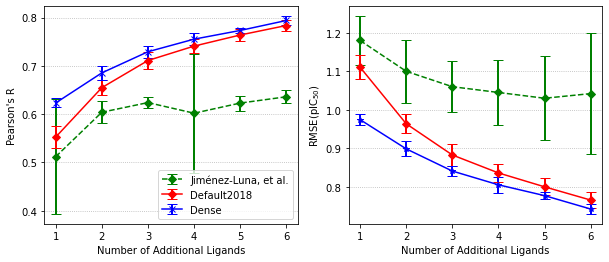

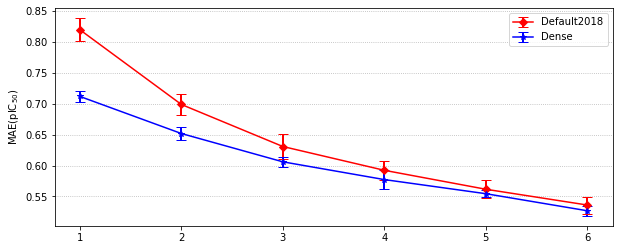

In [11]:
addnl_ligs_def2018['Addnl_Ligs'] = addnl_ligs_def2018['CSV_name'].apply(lambda x: int(x.split('/')[-1].split('.')[0].split('_')[-1]))
addnl_ligs_dense['Addnl_Ligs'] = addnl_ligs_dense['CSV_name'].apply(lambda x: int(x.split('/')[-1].split('.')[0].split('_')[-1]))
fig,axes = plt.subplots(1,2,figsize=(10,4))
# fig.add_subplot(121)
plt.axes(axes[0])
plt.errorbar(their_df['Addnl Ligs'],their_df['R'],yerr=their_df['R_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_def2018['Addnl_Ligs'],addnl_ligs_def2018['Avg_PearsonR'],yerr=addnl_ligs_def2018['Std_PearsonR'],label='Default2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_dense['Addnl_Ligs'],addnl_ligs_dense['Avg_PearsonR'],yerr=addnl_ligs_dense['Std_PearsonR'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='x')
plt.xlabel('Number of Additional Ligands')
plt.ylabel("Pearson's R")
plt.legend(loc='lower right')
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
# fig.add_subplot(221)
plt.axes(axes[1])
plt.errorbar(their_df['Addnl Ligs'],their_df['RMSE'],yerr=their_df['RMSE_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_def2018['Addnl_Ligs'],addnl_ligs_def2018['Avg_RMSE'],yerr=addnl_ligs_def2018['Std_RMSE'],label='ours',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_dense['Addnl_Ligs'],addnl_ligs_dense['Avg_RMSE'],yerr=addnl_ligs_dense['Std_RMSE'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
plt.xlabel('Number of Additional Ligands')
plt.ylabel("RMSE(pIC$_{50}$)")
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.savefig('figs/paper_comparison_main.pdf',bbox_inches="tight")
plt.figure(figsize=(10,4))
plt.errorbar(addnl_ligs_def2018['Addnl_Ligs'],addnl_ligs_def2018['Avg_MAE'],yerr=addnl_ligs_def2018['Std_MAE'],label='Default2018',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(addnl_ligs_dense['Addnl_Ligs'],addnl_ligs_dense['Avg_MAE'],yerr=addnl_ligs_dense['Std_MAE'],label='Dense',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
plt.ylabel("MAE(pIC$_{50}$)")
plt.legend()
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.savefig('figs/paper_comparison_mae.pdf')

# Ablation Study

In [57]:
ablated = ['noDDG','noDG','noRot','noCons','noDDG_noCons','noDG_noCons','Concat','NoSiam','combo','ConcatCombo']
ablation_study = build_graph(['models/addnl_ligs/def2018/statistics_1.csv']+[f'models/ablation/statistics_{abl}_1.csv' for abl in ablated])

In [58]:
ablation_study

,CSV_name,Avg_PearsonR,Avg_RMSE,Avg_MAE,Avg_Abs_PearsonR,Avg_Abs_RMSE,Avg_Abs_MAE,Std_PearsonR,Std_RMSE,Std_MAE,Std_Abs_PearsonR,Std_Abs_RMSE,Std_Abs_MAE
0,models/addnl_ligs/def2018/statistics_1.csv,0.552604,1.110560,0.819712,0.864032,0.840632,0.556012,0.023302,0.030937,0.018697,0.012390,0.037750,0.030285
1,models/ablation/statistics_noDDG_1.csv,0.551424,1.122000,0.828844,0.873104,0.814296,0.517024,0.020234,0.024783,0.017870,0.005695,0.018031,0.013592
2,models/ablation/statistics_noDG_1.csv,0.459012,1.271740,0.944888,0.027832,101.398608,100.966620,0.023756,0.028858,0.018245,0.107097,34.356581,34.503455
3,models/ablation/statistics_noRot_1.csv,0.555996,1.108440,0.819052,0.866248,0.833164,0.552544,0.018768,0.023273,0.016243,0.005904,0.016947,0.014078
4,models/ablation/statistics_noCons_1.csv,0.536428,1.138604,0.841756,0.866240,0.832556,0.558808,0.020997,0.035571,0.018636,0.005588,0.017131,0.015753
5,models/ablation/statistics_noDDG_noCons_1.csv,-0.057556,1.241520,0.908476,0.872964,0.813936,0.514372,0.135973,0.014318,0.014430,0.004250,0.013229,0.012050
6,models/ablation/statistics_noDG_noCons_1.csv,0.456404,1.276752,0.949708,-0.011832,6.648104,6.442196,0.023146,0.031897,0.023326,0.049432,0.464719,0.479720
7,models/ablation/statistics_Concat_1.csv,0.554364,1.110660,0.820776,0.869868,0.824284,0.530836,0.013441,0.022326,0.017384,0.004770,0.015513,0.015841
8,models/ablation/statistics_NoSiam_1.csv,0.500384,1.150380,0.854368,0.846268,0.883052,0.615904,0.034722,0.036192,0.021031,0.017474,0.047859,0.044158
9,models/ablation/statistics_combo_1.csv,0.511876,1.174988,0.876652,0.833848,0.919172,0.665716,0.021336,0.021327,0.015102,0.011091,0.023648,0.027019


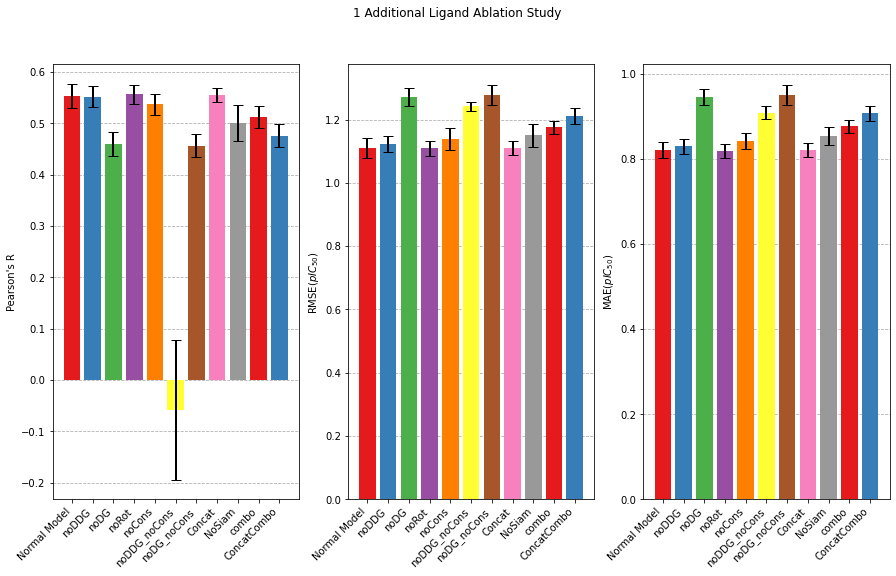

In [21]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.bar(range(len(ablated)+1),ablation_study['Avg_PearsonR'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_PearsonR'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['R'][0],tick_label='Normal Model',yerr=my_df['R_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel("Pearson's R")
plt.subplot(132)
plt.bar(range(len(ablated)+1),ablation_study['Avg_RMSE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_RMSE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel(r"RMSE($pIC_{50}$)")
plt.subplot(133)
plt.bar(range(len(ablated)+1),ablation_study['Avg_MAE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_MAE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel(r"MAE($pIC_{50}$)")
plt.suptitle('1 Additional Ligand Ablation Study')
# plt.savefig('ablation_study.pdf',dpi=300,bbox_inches='tight')
plt.show()

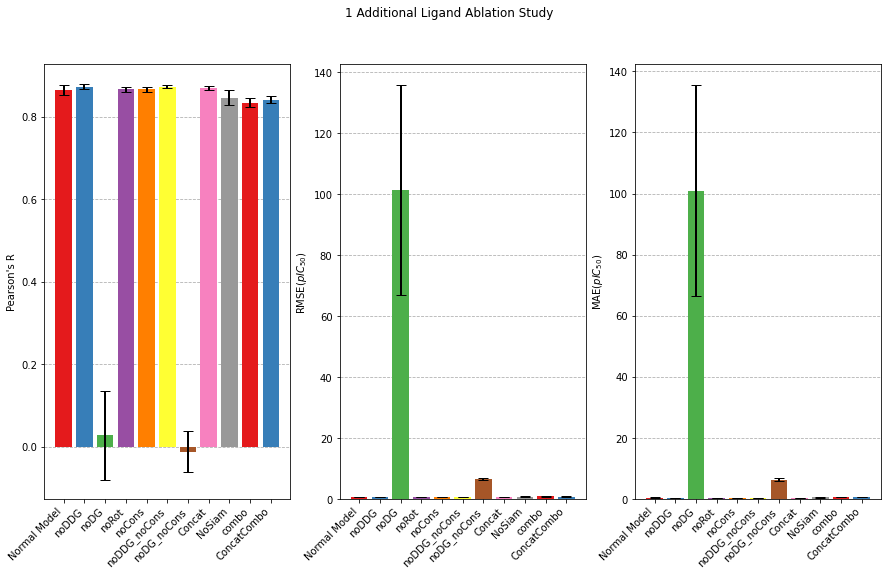

In [22]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.bar(range(len(ablated)+1),ablation_study['Avg_Abs_PearsonR'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_Abs_PearsonR'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['R'][0],tick_label='Normal Model',yerr=my_df['R_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel("Pearson's R")
plt.subplot(132)
plt.bar(range(len(ablated)+1),ablation_study['Avg_Abs_RMSE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_Abs_RMSE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel(r"RMSE($pIC_{50}$)")
plt.subplot(133)
plt.bar(range(len(ablated)+1),ablation_study['Avg_Abs_MAE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=ablation_study.index,yerr=ablation_study['Std_Abs_MAE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(ablated)+1)))
ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
ax.set_ylabel(r"MAE($pIC_{50}$)")
plt.suptitle('1 Additional Ligand Ablation Study')
plt.show()

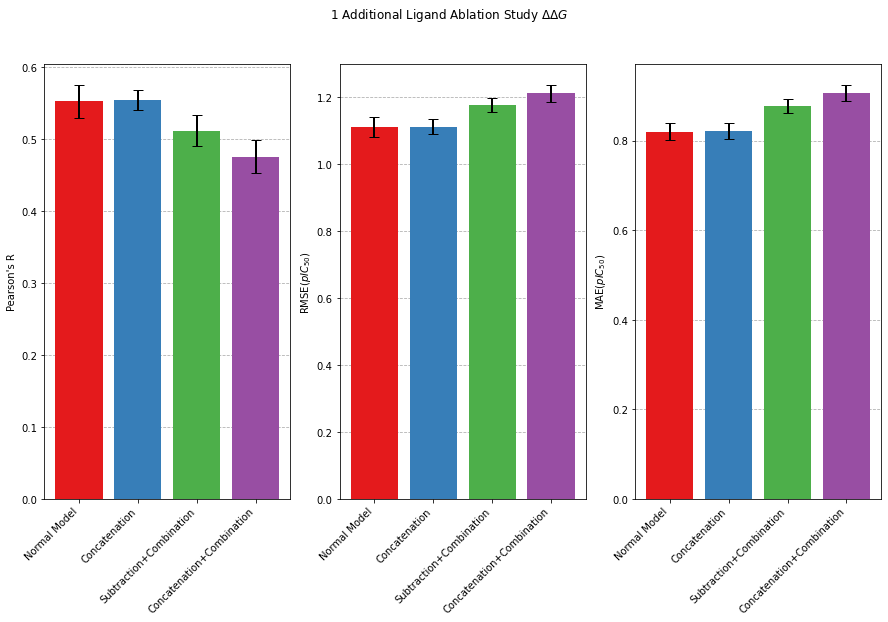

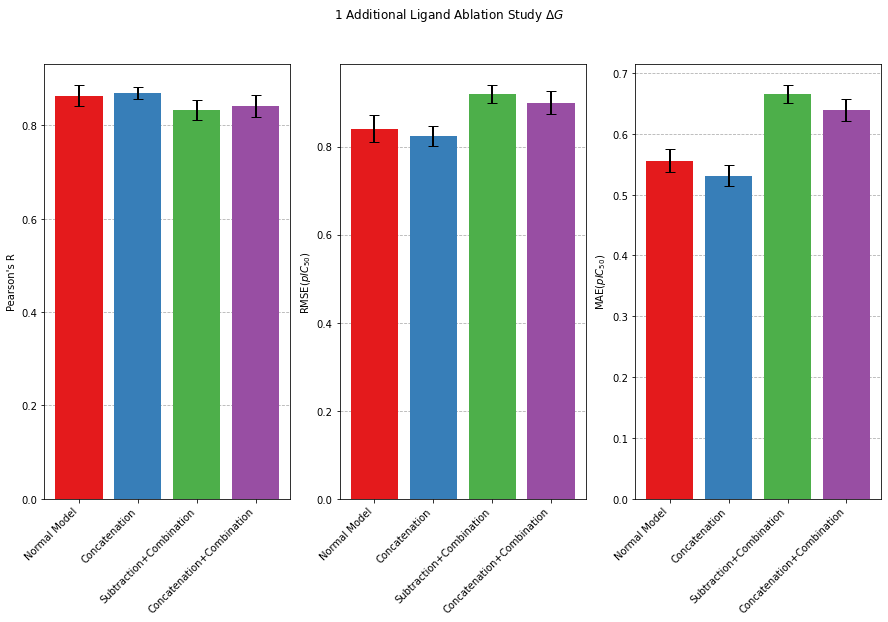

In [25]:
small_ablation_study = ablation_study[ablation_study['CSV_name'].isin(['models/addnl_ligs/def2018/statistics_1.csv',
                                                                 'models/ablation/statistics_Concat_1.csv',
                                                                 'models/ablation/statistics_combo_1.csv',
                                                                'models/ablation/statistics_ConcatCombo_1.csv'])]
ablated = ['Concatenation','Subtraction+Combination','Concatenation+Combination']
for figs in ['','_Abs']:
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)
    plt.figure(figsize=(15,8))
    plt.subplot(131)
    plt.bar(range(len(ablated)+1),small_ablation_study[f'Avg{figs}_PearsonR'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=small_ablation_study.index,yerr=small_ablation_study['Std_PearsonR'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    # plt.bar(1,my_df['R'][0],tick_label='Normal Model',yerr=my_df['R_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.grid(axis='y',linestyle='--')
    ax.set_xticks(list(range(len(ablated)+1)))
    ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
    ax.set_ylabel("Pearson's R")
    plt.subplot(132)
    plt.bar(range(len(ablated)+1),small_ablation_study[f'Avg{figs}_RMSE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=small_ablation_study.index,yerr=small_ablation_study['Std_RMSE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    # plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    ax = plt.gca()
    # ax.yaxis.set_label_position("right")
    # ax.yaxis.tick_right()
    ax.set_axisbelow(True)
    ax.grid(axis='y',linestyle='--')
    ax.set_xticks(list(range(len(ablated)+1)))
    ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
    ax.set_ylabel(r"RMSE($pIC_{50}$)")
    plt.subplot(133)
    plt.bar(range(len(ablated)+1),small_ablation_study[f'Avg{figs}_MAE'],color=plt.cm.Set1.colors[:len(ablated)+1],tick_label=small_ablation_study.index,yerr=small_ablation_study['Std_MAE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    # plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
    ax = plt.gca()
    # ax.yaxis.set_label_position("right")
    # ax.yaxis.tick_right()
    ax.set_axisbelow(True)
    ax.grid(axis='y',linestyle='--')
    ax.set_xticks(list(range(len(ablated)+1)))
    ax.set_xticklabels(['Normal Model']+ablated,rotation=45,ha='right')
    ax.set_ylabel(r"MAE($pIC_{50}$)")
    if figs == '_Abs':
        plt.suptitle('1 Additional Ligand Ablation Study $\Delta G$')
        plt.savefig('figs/combo_study_dg.pdf',dpi=300,bbox_inches='tight')
    else:
        plt.suptitle('1 Additional Ligand Ablation Study $\Delta\Delta G$')
        plt.savefig('figs/combo_study_ddg.pdf',dpi=300,bbox_inches='tight')
    # plt.savefig('ablation_study.pdf',dpi=300,bbox_inches='tight')
    plt.show()

In [24]:
class LDataFrame(pd.DataFrame):
    def __init__(self, df):
        self.__class__ = type(df.__class__.__name__,
                              (self.__class__, df.__class__),
                              {})
        self.__dict__ = df.__dict__

    def to_latex(self,filename,header=None,toprow=None):
        with open(filename,'w') as f:
            f.write("\\begin{tabular}{|" + " | ".join(["c"] * len(self.columns)) + "|} \\hline \n")
            if toprow:
                for i, (mult, string) in enumerate(toprow):
                    if i > 0:
                        f.write(" &")
                    if mult > 1:
                        f.write("\\multicolumn{{{}}}{{c|}}{{{}}}".format(mult,string))
                    else:
                        f.write(string)
                f.write(" \\\\ \\hline \n")
            if header:
                f.write(" & ".join([str(x) for x in header]) + " \\\\ \\hline \n")
            for i, row in self.iterrows():
                f.write(" & ".join([str(x) for x in row.values]) + " \\\\ \\hline \n")
            f.write("\\end{tabular}")

In [27]:
ablation_table = ablation_study.copy()
for metric in base_statistics:
    ablation_table[f"{metric}"] = ablation_table[[f"Avg_{metric}",f"Std_{metric}"]].apply(lambda x: r"${:.3g}(\pm {:.3g})$".format(x[0],x[1]),axis=1)
ablation_table.drop([col for col in ablation_table.columns if ('Avg' in col) or ('Std' in col)],axis=1, inplace=True)
ablated = ['noDDG','noDG','noRot','noCons','noDDG_noCons','noDG_noCons','Concat','NoSiam','combo','ConcatCombo']
ablation_table['CSV_name'] = ["Standard","No $L_{\Delta\Delta G}$",
                              "No $L_{\Delta G}$","No $L_{\mathrm{Rotation}}$",
                              "No $L_{\mathrm{Consistency}}$","No $L_{\Delta\Delta G}$ \& $L_{\mathrm{Consistency}}$",
                              "No $L_{\Delta G}$ \& $L_{\mathrm{Consistency}}$",
                              "Concatenation","No Siamese Network","Subtraction \& Combinations","Concatentation \& Combinations"]
# LDataFrame(ablation_table).to_latex("ablation_table.tex",
#                         header=['Ablation',"Pearson's R","RMSE","MAE","Pearson's R","RMSE", "MAE"],
#                         toprow=[(1,''),(3,'Relative Binding Free Energy'),(3,'Absolute Binding Free Energy')]
#                        )
ablation_table[['CSV_name',"PearsonR","RMSE","MAE"]].to_latex("figs/ablation_table_NIPS.tex",
                       header=['Ablation',"Pearson's R","RMSE","MAE"],
                        escape=False, index=False
                       )
ablation_table[['CSV_name',"Abs_PearsonR","Abs_RMSE","Abs_MAE"]].to_latex("figs/ablation_table_supp_NIPS.tex",
                       header=['Ablation',"Pearson's R","RMSE","MAE"],
                        escape=False, index=False
                       )

In [28]:
ablation_table

,CSV_name,PearsonR,RMSE,MAE,Abs_PearsonR,Abs_RMSE,Abs_MAE
0,Standard,$0.553(\pm 0.0233)$,$1.11(\pm 0.0309)$,$0.82(\pm 0.0187)$,$0.864(\pm 0.0124)$,$0.841(\pm 0.0377)$,$0.556(\pm 0.0303)$
1,No $L_{\Delta\Delta G}$,$0.551(\pm 0.0202)$,$1.12(\pm 0.0248)$,$0.829(\pm 0.0179)$,$0.873(\pm 0.0057)$,$0.814(\pm 0.018)$,$0.517(\pm 0.0136)$
2,No $L_{\Delta G}$,$0.459(\pm 0.0238)$,$1.27(\pm 0.0289)$,$0.945(\pm 0.0182)$,$0.0278(\pm 0.107)$,$101(\pm 34.4)$,$101(\pm 34.5)$
3,No $L_{\mathrm{Rotation}}$,$0.556(\pm 0.0188)$,$1.11(\pm 0.0233)$,$0.819(\pm 0.0162)$,$0.866(\pm 0.0059)$,$0.833(\pm 0.0169)$,$0.553(\pm 0.0141)$
4,No $L_{\mathrm{Consistency}}$,$0.536(\pm 0.021)$,$1.14(\pm 0.0356)$,$0.842(\pm 0.0186)$,$0.866(\pm 0.00559)$,$0.833(\pm 0.0171)$,$0.559(\pm 0.0158)$
5,No $L_{\Delta\Delta G}$ \& $L_{\mathrm{Consist...,$-0.0576(\pm 0.136)$,$1.24(\pm 0.0143)$,$0.908(\pm 0.0144)$,$0.873(\pm 0.00425)$,$0.814(\pm 0.0132)$,$0.514(\pm 0.0121)$
6,No $L_{\Delta G}$ \& $L_{\mathrm{Consistency}}$,$0.456(\pm 0.0231)$,$1.28(\pm 0.0319)$,$0.95(\pm 0.0233)$,$-0.0118(\pm 0.0494)$,$6.65(\pm 0.465)$,$6.44(\pm 0.48)$
7,Concatenation,$0.554(\pm 0.0134)$,$1.11(\pm 0.0223)$,$0.821(\pm 0.0174)$,$0.87(\pm 0.00477)$,$0.824(\pm 0.0155)$,$0.531(\pm 0.0158)$
8,No Siamese Network,$0.5(\pm 0.0347)$,$1.15(\pm 0.0362)$,$0.854(\pm 0.021)$,$0.846(\pm 0.0175)$,$0.883(\pm 0.0479)$,$0.616(\pm 0.0442)$
9,Subtraction \& Combinations,$0.512(\pm 0.0213)$,$1.17(\pm 0.0213)$,$0.877(\pm 0.0151)$,$0.834(\pm 0.0111)$,$0.919(\pm 0.0236)$,$0.666(\pm 0.027)$


## Evaluate difference in performance when permutation vs combination train

In [29]:
from python_files.multtask_latent_def2018_concat_model import Net as ConcatNet
from python_files.multtask_latent_def2018_model import Net as SubtractNet
def evaluate_reverse(model_files,stats_save_name):
    stats_list=[]
    for model_file in model_files:
        print(model_file)
        if 'Concat' in model_file:
            Net = ConcatNet
        else:
            Net = SubtractNet
        
        test_data = molgrid.ExampleProvider(ligmolcache=f"cache/lig_full_bdb.molcache2",
                                        recmolcache=f"cache/rec_full_bdb.molcache2", 
                                    shuffle=True, duplicate_first=True, default_batch_size=16,
                                    iteration_scheme=molgrid.IterationScheme.LargeEpoch)
        testfile_num = model_file.split('.')[0].split('_')[-1]
        test_data.populate(f"new_Prot_Lig_Valid/all_data_test_papersplit_rand{testfile_num}_c_1.types")

        gmaker = molgrid.GridMaker()      
        dims = gmaker.grid_dimensions(14*4)  # only one rec+onelig per example      
        tensor_shape = (16,)+dims      

        args = Namespace(dropout=0,hidden_size=0)
        actual_dims = (dims[0]//2, *dims[1:])      
        model = Net(actual_dims,args).to('cuda')

        pretrained_state_dict = torch.load(model_file)      
        model_dict = model.state_dict()      
        pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}      
        model_dict.update(pretrained_dict)      
        model.load_state_dict(model_dict)
        
        input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
        float_labels = torch.zeros(16, dtype=torch.float32)
        lig1_label = torch.zeros(16, dtype=torch.float32)
        lig2_label = torch.zeros(16, dtype=torch.float32)

        #running test loop
        model.eval()

        output_dist, output_dist_reverse, actual, actual_reverse = [], [], [], []
        lig_pred, lig_labels = [], []
        with torch.no_grad():
            for idx, batch in enumerate(test_data):        
                gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
                batch.extract_label(1, float_labels)
                labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
                batch.extract_label(2, lig1_label)
                batch.extract_label(3, lig2_label)
                lig1_labels = torch.unsqueeze(lig1_label, 1).float().to('cuda')
                lig2_labels = torch.unsqueeze(lig2_label, 1).float().to('cuda')
                output, lig1, lig2, _, _ = model(input_tensor_1[:, :28, :, :, :], input_tensor_1[:, 28:, :, :, :])
                output_reverse, lig1, lig2, _, _ = model(input_tensor_1[:, 28:, :, :, :], input_tensor_1[:, :28, :, :, :])
                lig_pred += lig1.flatten().tolist() + lig2.flatten().tolist()
                lig_labels += lig1_labels.flatten().tolist() + lig2_labels.flatten().tolist()
                output_dist += output.flatten().tolist()
                actual += labels.flatten().tolist()
                output_dist_reverse += output_reverse.flatten().tolist()
                actual_reverse += (-labels).flatten().tolist()
            
        r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
        r_full, rmse_full, mae_full = get_stats(0,output_dist+output_dist_reverse,actual+actual_reverse,lig_pred,lig_labels)
        
        stats_list.append([testfile_num,r[0],r_full[0],rmse[0],rmse_full[0], mae[0],mae_full[0],(np.array(output_dist)+np.array(output_dist_reverse)).mean()])
        
    final_stats = pd.DataFrame(stats_list,columns=['randval','PearsonR','R_Full','RMSE', 'RMSE_Full','MAE','MAE_Full','Avg Diff'])
    final_stats.to_csv(f"{stats_save_name}",index=False,float_format="%.4f")
    return final_stats

In [27]:
# final_stats = evaluate_reverse(glob('models/addnl_ligs/def2018/model_1_*.h5'),'models/ablation/everything_eval_perms.csv')
# final_stats_concat = evaluate_reverse(glob('models/ablation/model_Concat_1_*.h5'),'models/ablation/concat_eval_perms.csv')
final_stats_combo = evaluate_reverse(glob('models/ablation/model_combo_1_*.h5'),'models/ablation/everything_combo_eval_perms.csv')
final_stats_concatcombo = evaluate_reverse(glob('models/ablation/model_ConcatCombo_1_*.h5'),'models/ablation/concat_combo_eval_perms.csv')

models/ablation/model_combo_1_15.h5
27648
models/ablation/model_combo_1_10.h5
27648
models/ablation/model_combo_1_21.h5
27648
models/ablation/model_combo_1_8.h5
27648
models/ablation/model_combo_1_6.h5
27648
models/ablation/model_combo_1_9.h5
27648
models/ablation/model_combo_1_16.h5
27648
models/ablation/model_combo_1_2.h5
27648
models/ablation/model_combo_1_13.h5
27648
models/ablation/model_combo_1_17.h5
27648
models/ablation/model_combo_1_0.h5
27648
models/ablation/model_combo_1_4.h5
27648
models/ablation/model_combo_1_12.h5
27648
models/ablation/model_combo_1_19.h5
27648
models/ablation/model_combo_1_20.h5
27648
models/ablation/model_combo_1_22.h5
27648
models/ablation/model_combo_1_1.h5
27648
models/ablation/model_combo_1_18.h5
27648
models/ablation/model_combo_1_7.h5
27648
models/ablation/model_combo_1_5.h5
27648
models/ablation/model_combo_1_11.h5
27648
models/ablation/model_combo_1_14.h5
27648
models/ablation/model_combo_1_23.h5
27648
models/ablation/model_combo_1_3.h5
27648
mo

In [59]:
final_stats = pd.read_csv('models/ablation/everything_eval_perms.csv')
final_stats_concat = pd.read_csv('models/ablation/concat_eval_perms.csv')
final_stats_combo = pd.read_csv('models/ablation/everything_combo_eval_perms.csv')
final_stats_concatcombo = pd.read_csv('models/ablation/concat_combo_eval_perms.csv')

In [63]:
with open("figs/permute_vs_combo.tex","w") as pvc:
    pvc.write('\\begin{tabular}{l l} \n')
    pvc.write("\\toprule \n Ablation & Difference from Reverse Prediction ($\mathrm{pIC}_{50}$) \\\\ \\midrule \n")
    for evaluation,model_name in zip([final_stats,final_stats_combo,final_stats_concat,final_stats_concatcombo],['Normal Model','Subtraction \& Combinations','Concatenation','Concatenation \& Combinations']):
        pvc.write(f"\t {model_name} & {evaluation['Avg Diff'].mean():.4f} (\pm {evaluation['Avg Diff'].std():.4f}) \\\\ \n")
    pvc.write("\\bottomrule \n \\end{tabular}")
# print('{:.4f} & {:.4f} & {:.4f} & {:.4f} \\\\'.format(final_stats['Avg Diff'].mean(),final_stats_concat['Avg Diff'].mean(),final_stats_combo['Avg Diff'].mean(),final_stats_concatcombo['Avg Diff'].mean()))
# print('{:.4f} & {:.4f} & {:.4f} & {:.4f} \\\\'.format(final_stats['Avg Diff'].std(),final_stats_concat['Avg Diff'].std(),final_stats_combo['Avg Diff'].std(),final_stats_concatcombo['Avg Diff'].std()))

# Evaluate Absolute Affinity Prediction

In [167]:
from python_files.default2018_single_model import Net
def eval_abs_pred(model_files):
    stats_list=[]
    test_data = molgrid.ExampleProvider(data_root='/home/anm329/Docking/refined_set_input', 
                                    shuffle=True, default_batch_size=32,
                                    iteration_scheme=molgrid.IterationScheme.LargeEpoch)
    testfile_num = model_file.split('/')[-1].split('.')[0].split('_')[-1]
    test_data.populate(f"/home/anm329/Docking/core_not_ddg.types")

    gmaker = molgrid.GridMaker()      
    dims = gmaker.grid_dimensions(14*2)  # only one rec+onelig per example      
    tensor_shape = (32,)+dims      

    args = Namespace(dropout=0,hidden_size=0)   
    model = Net(dims,args).to('cuda')
    for idx,model_file in enumerate(model_files):
        print(idx)
        

        pretrained_state_dict = torch.load(model_file)      
        model_dict = model.state_dict()
        pretrained_state_dict['last_fc.weight']=pretrained_state_dict['affinity.weight']
        pretrained_state_dict['last_fc.bias']=pretrained_state_dict['affinity.bias']
        pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}
#         print(pretrained_dict.keys())
        model_dict.update(pretrained_dict)      
        load_info = model.load_state_dict(model_dict)
#         print(load_info)
        
        input_tensor_1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
        float_labels = torch.zeros(32, dtype=torch.float32)

        #running test loop
        model.eval()

        output_dist, output_dist_reverse, actual, actual_reverse = [], [], [], []
        lig_pred, lig_labels = [], []
        with torch.no_grad():
            for idx, batch in enumerate(test_data):        
                gmaker.forward(batch, input_tensor_1, random_translation=2.0, random_rotation=True) 
                batch.extract_label(0, float_labels)
                labels = torch.unsqueeze(float_labels, 1).float().to('cuda')
                output = model(input_tensor_1)
                output_dist += output.flatten().tolist()
                actual += labels.flatten().tolist()
            
        r, rmse, mae = get_stats(0,output_dist,actual,lig_pred,lig_labels)
        
        stats_list.append([testfile_num,r[0],rmse[0], mae[0]])
        
        
    return pd.DataFrame(stats_list,columns=['randval','PearsonR','RMSE','MAE'])

In [185]:
def eval_gnina_cnns(affinities_list):
    stats_list = []
    actual = pd.read_csv("/home/anm329/Docking/core_not_ddg.types",sep=' ',header=None)
    for affinities in affinities_list:
        affs = pd.read_csv(affinities,header=None,sep=' ')[0].astype(float).tolist()
        r, rmse, mae = get_stats(0,[],[],affs,actual[0].to_list())
        stats_list.append([r[1],rmse[1],mae[1]])
    return pd.DataFrame(stats_list,columns=['PearsonR','RMSE','MAE']) 

In [186]:
crossdock_default2018_stats = eval_gnina_cnns(glob('models/crossdock_default2018*_affinities.txt'))
general_default2018_stats = eval_gnina_cnns(glob('models/general_default2018*_affinities.txt'))
redock_default2018_stats = eval_gnina_cnns(glob('models/redock_default2018*_affinities.txt'))
crossdock_default2018_stats.to_csv('models/crossdock_default2018_statistics.csv')
redock_default2018_stats.to_csv('models/redock_default2018_statistics.csv')
general_default2018_stats.to_csv('models/general_default2018_statistics.csv')

0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.
0:x and y must have length at least 2.


<ipython-input-83-1e34f3aeba5a>:14: RuntimeWarning: Mean of empty slice.
  rmse_ddg = np.sqrt(((np.array(pred_ddg)-np.array(actual_ddg)) ** 2).mean())
<ipython-input-83-1e34f3aeba5a>:18: RuntimeWarning: Mean of empty slice.
  mae = (np.abs(np.array(pred_ddg)-np.array(actual_ddg)).mean(),


#### Downloading Def2018 models trained on all BDB data

In [164]:
model="multtask_latent_def2018"
weight_decay=0
ddg_weight=10
consistency_weight=1
absolute_weight=1
rotation_weight=1
use_weights=None
model_save_path = 'models/fullTrain/def2018/'
spec_name=''
runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},{'tags':f'TrainAllPerms'},
                                        {"config.rot_warmup":0},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},
                                        {"state":"finished"}]})
for randval, run in enumerate(runs):
    if not os.path.isfile(f"{model_save_path}model{spec_name}_{randval}.h5"):
            run.file('model.h5').download(root=model_save_path)
            os.rename(f"{model_save_path}model.h5",f"{model_save_path}model{spec_name}_{randval}.h5")

In [168]:
full_train = eval_abs_pred(glob('models/fullTrain/def2018/model_*.h5'))
full_train.to_csv('models/fullTrain/def2018/statistics_absaff.csv')

27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])
0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])


<ipython-input-83-1e34f3aeba5a>:15: RuntimeWarning: Mean of empty slice.
  rmse_abs = np.sqrt(((np.array(pred_abs)-np.array(actual_abs)) ** 2).mean())
<ipython-input-83-1e34f3aeba5a>:19: RuntimeWarning: Mean of empty slice.
  np.abs(np.array(pred_abs)-np.array(actual_abs)).mean())


0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])
0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])
0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_conv.bias', 'unit3_conv.weight', 'unit3_conv.bias', 'unit4_conv.weight', 'unit4_conv.bias', 'unit5_conv.weight', 'unit5_conv.bias', 'last_fc.weight', 'last_fc.bias'])
0:x and y must have length at least 2.
27648
dict_keys(['unit1_conv.weight', 'unit1_conv.bias', 'unit2_conv.weight', 'unit2_con

In [178]:
base_statistics = ['PearsonR','RMSE','MAE']
avg_std_base_statistics = [f'Avg_{base}' for base in base_statistics] + [f'Std_{base}' for base in base_statistics]
def build_abs_graph(list_csvs):
    stats_list = []
    for csv in list_csvs:
        data = pd.read_csv(csv)
        avgs = data[base_statistics].mean(axis=0)
        stds = data[base_statistics].std(axis=0)
        stats_list.append([csv] + avgs.values.tolist()+stds.values.tolist())
#     print(stats_list)
    return pd.DataFrame(stats_list,columns=['CSV_name']+avg_std_base_statistics)

In [187]:
absolute_affinity_comparisons = build_abs_graph(['models/fullTrain/def2018/statistics_absaff.csv']+[f'models/{dset}_default2018_statistics.csv' for dset in ['redock','crossdock','general']])

In [200]:
absolute_affinity_comparisons.index = absolute_affinity_comparisons['CSV_name'].apply(
    lambda x: x.split('/')[-1].split('.')[0].replace('_statistics','').replace('_',' ').title())

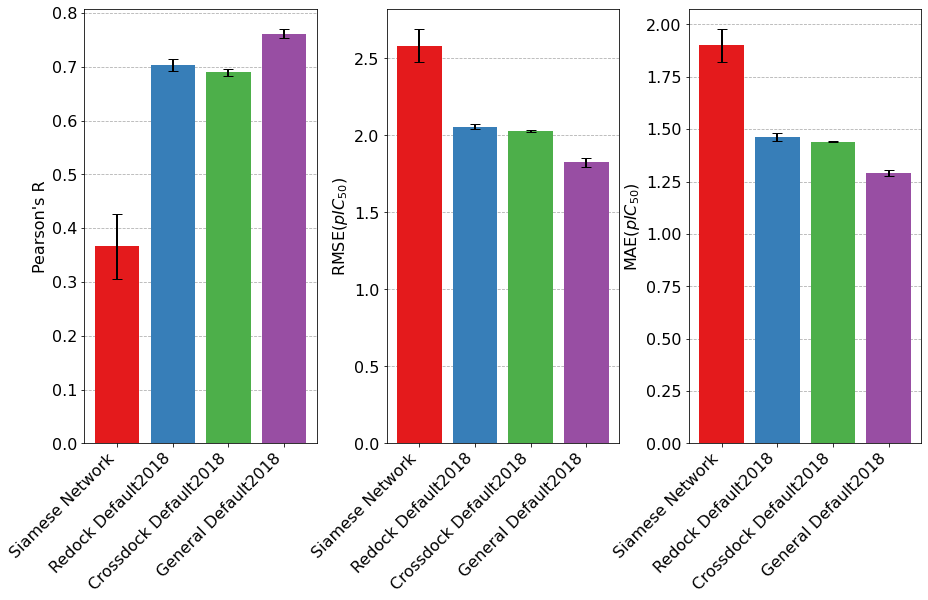

In [226]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)
fig = plt.figure(figsize=(15,8),subplotpars=matplotlib.figure.SubplotParams(wspace=0.3))
plt.subplot(131)
plt.bar(range(len(absolute_affinity_comparisons)),absolute_affinity_comparisons['Avg_PearsonR'],color=plt.cm.Set1.colors[:len(absolute_affinity_comparisons)+1],tick_label=absolute_affinity_comparisons.index,yerr=absolute_affinity_comparisons['Std_PearsonR'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['R'][0],tick_label='Normal Model',yerr=my_df['R_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(absolute_affinity_comparisons))))
ax.set_xticklabels(['Siamese Network'] + absolute_affinity_comparisons.index[1:].tolist(),rotation=45,ha='right')
ax.set_ylabel("Pearson's R")
plt.subplot(132)
plt.bar(range(len(absolute_affinity_comparisons)),absolute_affinity_comparisons['Avg_RMSE'],color=plt.cm.Set1.colors[:len(absolute_affinity_comparisons)+1],tick_label=absolute_affinity_comparisons.index,yerr=absolute_affinity_comparisons['Std_RMSE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(absolute_affinity_comparisons))))
ax.set_xticklabels(['Siamese Network'] + absolute_affinity_comparisons.index[1:].tolist(),rotation=45,ha='right')
ax.set_ylabel(r"RMSE($pIC_{50}$)")
plt.subplot(133)
plt.bar(range(len(absolute_affinity_comparisons)),absolute_affinity_comparisons['Avg_MAE'],color=plt.cm.Set1.colors[:len(absolute_affinity_comparisons)],tick_label=absolute_affinity_comparisons.index,yerr=absolute_affinity_comparisons['Std_MAE'],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
# plt.bar(1,my_df['RMSE'][0],tick_label='Normal Model',yerr=my_df['RMSE_std'][0],capsize=5,error_kw={"markeredgewidth":1,"elinewidth":2})
ax = plt.gca()
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_axisbelow(True)
ax.grid(axis='y',linestyle='--')
ax.set_xticks(list(range(len(absolute_affinity_comparisons))))
ax.set_xticklabels(['Siamese Network'] + absolute_affinity_comparisons.index[1:].tolist(),rotation=45,ha='right')
ax.set_ylabel(r"MAE($pIC_{50}$)")
# plt.suptitle('Absolute Affinity Prediction')
plt.savefig('figs/absolute_affinity_comparison.pdf',bbox_inches='tight')

# Evaluating LOO-PFAM

In [207]:
model="multtask_latent_def2018"
weight_decay=0
ddg_weight=10
consistency_weight=1
absolute_weight=1
rotation_weight=1
use_weights=None
model_save_path = 'models/LOO-PFAM/def2018/'
spec_name=''
loopfam_runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
                       filters={"$and":[{"config.use_model":model},{'tags':f'BASE_PFAM'},
                                        {"config.rot_warmup":0},{"config.weight_decay":weight_decay},
                                        {"config.solver":"adam"},{"config.ddg_loss_weight":ddg_weight},
                                        {"config.consistency_loss_weight":consistency_weight},
                                        {"config.absolute_loss_weight":absolute_weight},
                                        {"config.rotation_loss_weight":rotation_weight},
                                        {"config.use_weights":use_weights},
                                        {"$or":[{"state":"finished"},{"state":"running"}]}]})
print(len(loopfam_runs))

73


In [208]:
def create_stats_loo_pfam(model_save_path,runs):
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    rands = []
    stats_list = []
    predictions = []
    actual = []
    for run in runs:
        saved_tag = ''
        if run.state == 'running' and len(run.history()) < 50:
            continue
        for t in run.tags:
            if 'CV_' in t:
                saved_tag = t.replace('CV_','')
        assert len(saved_tag)
        if not os.path.isfile(f"{model_save_path}model_{saved_tag}.h5"):
            run.file('model.h5').download(root=model_save_path)
            os.rename(f"{model_save_path}model.h5",f"{model_save_path}model_{saved_tag}.h5")

        config = Namespace()
        for k,v in run.config.items():
            setattr(config,k,v)

        r,rmse, mae, vals = get_eval(config,f"{model_save_path}model_{saved_tag}.h5",return_vals=True)
        print(saved_tag,r,rmse,mae)
        stats_list.append([saved_tag,len(vals[0]),r[0],rmse[0],mae[0],r[1],rmse[1],mae[1]])
        predictions += vals[0]
        actual += vals[1]
        
        
    final_stats = pd.DataFrame(stats_list,columns=['PFAM','Test Size','PearsonR','RMSE','MAE','Abs_PearsonR','Abs_RMSE','Abs_MAE'])
    final_stats.to_csv(f"{model_save_path}statistics.csv",index=False,float_format="%.4f")
    
    return final_stats, (predictions, actual)

In [209]:
loo_pfam_stats, LOO_PFAM_pred_act = create_stats_loo_pfam('models/LOO-PFAM/def2018/',loopfam_runs)

27648
An_peroxidase (-0.7315410757641359, -0.7274280633148896) (1.0231984792122237, 0.8267344999399069) (0.8260188419371843, 0.8078060746192932)
27648
IDO (0.5837011161894314, 0.5649308340135666) (1.1071712967255285, 1.027331871864553) (0.8930369975802023, 0.8945320799946785)
27648
AMP-binding (0.05466733497938201, -0.004366369149699886) (1.1690899400802135, 1.116935354178415) (0.8923685759239431, 0.971652186342648)
27648
Amidinotransf (-0.486294780296953, -0.36477653362624773) (1.8486785628498057, 1.2235638553225974) (1.4190313419118563, 0.9240574104090532)
27648
Scytalone_dh (0.19558632032054063, 0.22741573439430474) (1.747178379664841, 2.1988508391361985) (1.5835615321411751, 1.8178287148475647)
27648
Methyltransf_25 (-0.9842664033408232, -0.9580503082964051) (1.5981679502195525, 4.32508175916667) (1.5836597830057144, 4.242495685815811)
27648
DHFR_1 (0.12283632658069729, 0.034318266641461) (1.129490473296183, 2.8229212408235114) (0.8561191211121145, 2.6158053413206757)
27648
Pep_def

Asp (0.11820118878735177, 0.2868963925943153) (1.2888186046779428, 1.6535650469202525) (0.9917111237848655, 1.406824268400669)
27648
Phosphorylase (-0.1977876320000046, -0.1998679101055293) (1.1672901035426062, 1.3356761365864849) (0.904228185285839, 1.1361384152301721)
27648
Thymidylat_synt (-0.37494134585417305, 0.07792508188584826) (1.6304719854379408, 1.3031042302172318) (1.2165200297339736, 0.9915716834366322)
27648
Lig_chan-Glu_bd (0.1470263278367957, 0.11226611123706752) (1.713741632470126, 2.6934382918250903) (1.2707094355485213, 2.4782340108202052)
27648
F_bP_aldolase (0.9878299345038767, 0.9591758027273121) (0.37929964585898, 1.7629042921612639) (0.305947445333004, 1.6965962797403336)
27648
RnaseA (0.493650031598008, 0.4568049148755475) (1.2543093423681366, 1.3189983758352897) (1.0144258526793946, 1.1030517885727542)
27648
Peptidase_C1 (0.24974106460664308, 0.055302808951599954) (1.686207879691233, 2.0368182112357625) (1.3159492936141541, 1.674203418322608)
27648
Y_phosphatas

In [210]:
loo_pfam_stats

,PFAM,Test Size,PearsonR,RMSE,MAE,Abs_PearsonR,Abs_RMSE,Abs_MAE
0,An_peroxidase,16,-0.731541,1.023198,0.826019,-0.727428,0.826734,0.807806
1,IDO,160,0.583701,1.107171,0.893037,0.564931,1.027332,0.894532
2,AMP-binding,224,0.054667,1.169090,0.892369,-0.004366,1.116935,0.971652
3,Amidinotransf,96,-0.486295,1.848679,1.419031,-0.364777,1.223564,0.924057
4,Scytalone_dh,16,0.195586,1.747178,1.583562,0.227416,2.198851,1.817829
...,...,...,...,...,...,...,...,...
68,Carb_anhydrase,8896,0.032928,1.354629,0.932795,-0.115793,2.146126,1.680970
69,SH2,128,0.176151,2.019035,1.662915,0.218103,2.217698,1.685209
70,BIR,480,0.027402,1.338265,1.059915,0.015174,1.380969,1.128527
71,EPSP_synthase,416,-0.611740,2.303452,1.781349,-0.319005,2.686847,2.312917


In [211]:
sorted_loopfam['Test Size'].min()

16

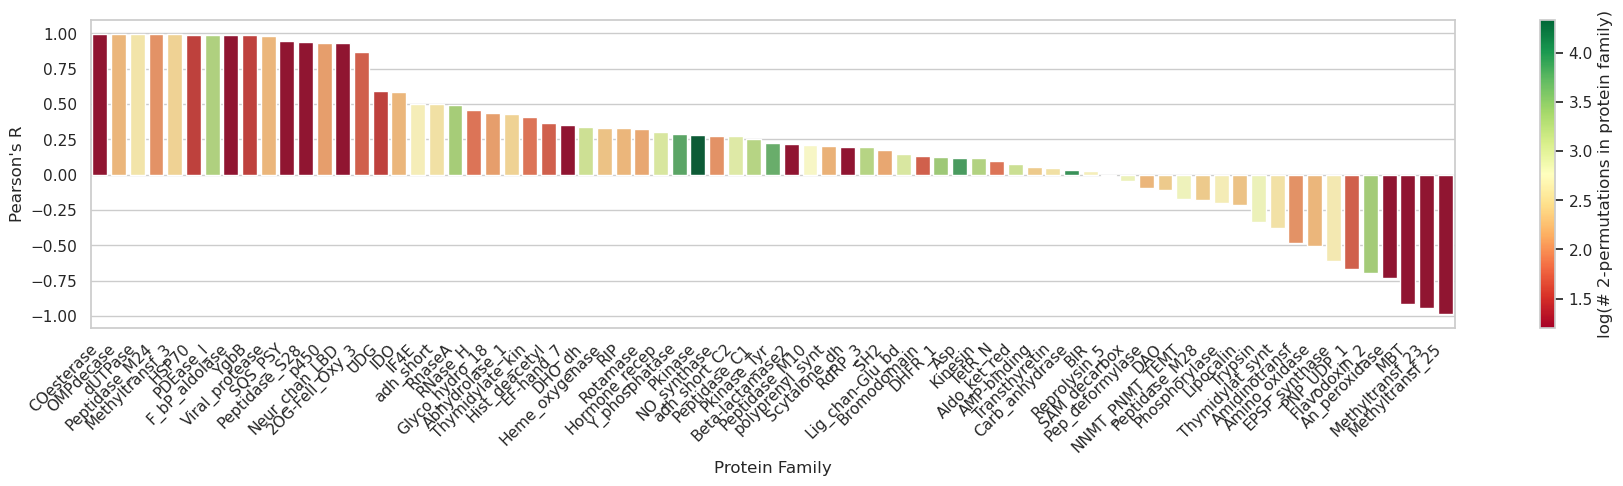

In [220]:
import seaborn as sns
from matplotlib.colors import DivergingNorm
sorted_loopfam = loo_pfam_stats.sort_values(['PearsonR'],ascending=False)
sns.set(rc={"figure.figsize":(22, 4)})
sns.set_theme(style="whitegrid")
norm = plt.Normalize(vmin=np.log10(sorted_loopfam['Test Size'].min()), vmax=np.log10(sorted_loopfam['Test Size'].max()))
colors = [plt.cm.RdYlGn(norm(np.log10(c))) for c in sorted_loopfam['Test Size']]
chart = sns.barplot(x='PFAM',y='PearsonR',data=sorted_loopfam,palette=colors)
_ = chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel("Pearson's R")
chart.set_xlabel("Protein Family")

# norm = plt.Normalize(sorted_loopfam['Test Size'].min(), sorted_loopfam['Test Size'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# chart.get_legend().remove()
chart.figure.colorbar(sm,label="log(# 2-permutations in protein family)")
plt.savefig('figs/LOO_pfam_R.pdf',bbox_inches="tight")

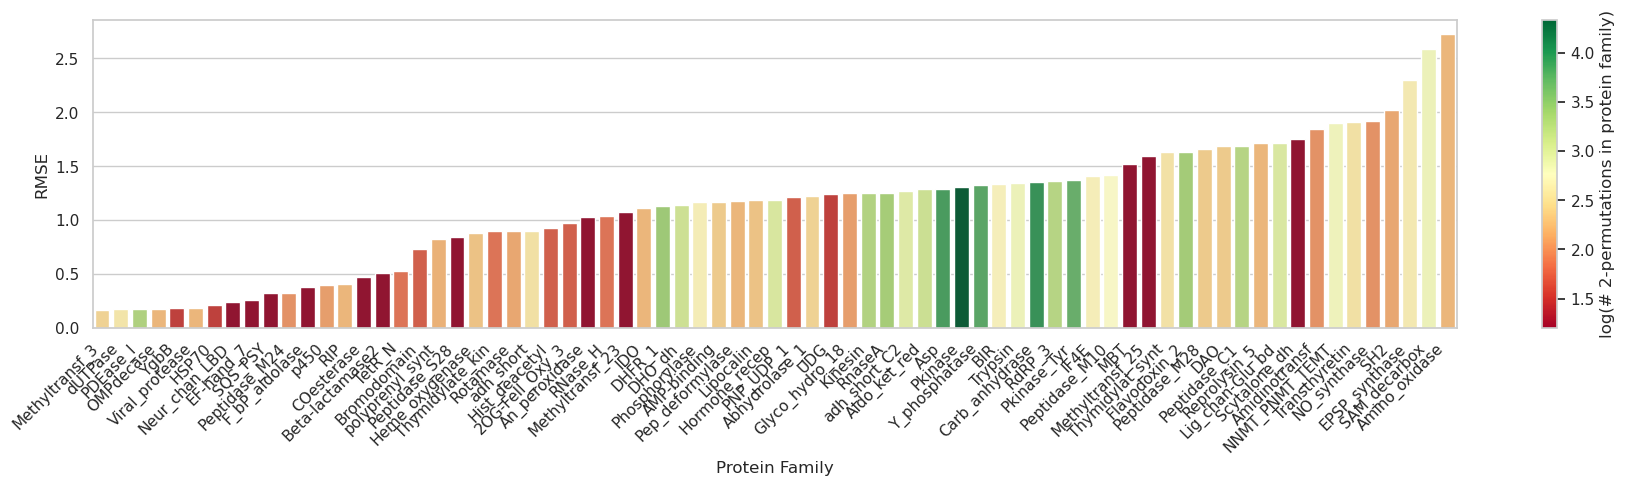

In [221]:
sorted_loopfam = loo_pfam_stats.sort_values(['RMSE'])
sns.set(rc={"figure.figsize":(22, 4)})
sns.set_theme(style="whitegrid")
norm = plt.Normalize(vmin=np.log10(sorted_loopfam['Test Size'].min()), vmax=np.log10(sorted_loopfam['Test Size'].max()))
colors = [plt.cm.RdYlGn(norm(np.log10(c))) for c in sorted_loopfam['Test Size']]
chart = sns.barplot(x='PFAM',y='RMSE',data=sorted_loopfam,palette=colors)
_ = chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel("RMSE")
chart.set_xlabel("Protein Family")

# norm = plt.Normalize(sorted_loopfam['Test Size'].min(), sorted_loopfam['Test Size'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# chart.get_legend().remove()
chart.figure.colorbar(sm,label="log(# 2-permutations in protein family)")
plt.savefig('figs/LOO_pfam_RMSE.pdf',bbox_inches="tight")

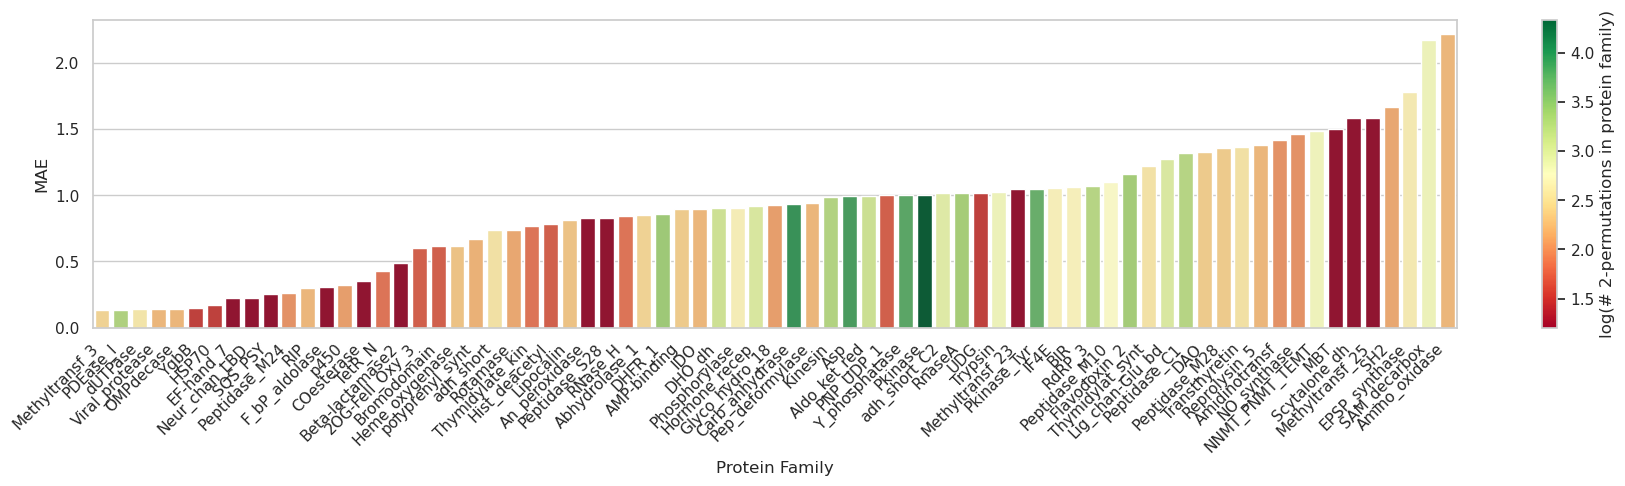

In [222]:
sorted_loopfam = loo_pfam_stats.sort_values(['MAE'])
sns.set(rc={"figure.figsize":(22, 4)})
sns.set_theme(style="whitegrid")
norm = plt.Normalize(vmin=np.log10(sorted_loopfam['Test Size'].min()), vmax=np.log10(sorted_loopfam['Test Size'].max()))
colors = [plt.cm.RdYlGn(norm(np.log10(c))) for c in sorted_loopfam['Test Size']]
chart = sns.barplot(x='PFAM',y='MAE',data=sorted_loopfam,palette=colors)
_ = chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel("MAE")
chart.set_xlabel("Protein Family")

# norm = plt.Normalize(sorted_loopfam['Test Size'].min(), sorted_loopfam['Test Size'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# chart.get_legend().remove()
chart.figure.colorbar(sm,label="log(# 2-permutations in protein family)")
plt.savefig('figs/LOO_pfam_MAE.pdf',bbox_inches="tight")

In [215]:
print(get_stats(0,LOO_PFAM_pred_act[0],LOO_PFAM_pred_act[1],[],[]))
print("mean:",loo_pfam_stats.mean())
print("min:",loo_pfam_stats.min())
print("max:",loo_pfam_stats.max())

0:x and y must have length at least 2.
((0.23024495087176994, nan), (1.3425082083139122, nan), (0.9924760604350054, nan))
mean: Test Size       1117.150685
PearsonR           0.228986
RMSE               1.131788
MAE                0.899656
Abs_PearsonR       0.206671
Abs_RMSE           1.486413
Abs_MAE            1.278549
dtype: float64
min: PFAM            2OG-FeII_Oxy_3
Test Size                   16
PearsonR             -0.984266
RMSE                  0.165276
MAE                   0.133894
Abs_PearsonR          -0.95805
Abs_RMSE              0.156574
Abs_MAE               0.122599
dtype: object
max: PFAM            polyprenyl_synt
Test Size                 21648
PearsonR               0.997518
RMSE                   2.723995
MAE                    2.213694
Abs_PearsonR           0.993351
Abs_RMSE               4.544848
Abs_MAE                4.457807
dtype: object


<ipython-input-200-3a307f08a6e2>:15: RuntimeWarning: Mean of empty slice.
  rmse_abs = np.sqrt(((np.array(pred_abs)-np.array(actual_abs)) ** 2).mean())
/home/anm329/anaconda3/envs/py38_torch/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-200-3a307f08a6e2>:19: RuntimeWarning: Mean of empty slice.
  np.abs(np.array(pred_abs)-np.array(actual_abs)).mean())


# Evaluating External Finetune

In [108]:
# create_stats('models/full_train/def2018/',spec_name='',num_addnl=None)
# create_stats('models/full_train/dense/',spec_name='',num_addnl=None,model='multtask_latent_dense', weight_decay=0.01, use_weights='gnina_weights/dense_model.pt', num_runs=5)
def2018_ft0 = pd.read_csv('models/full_train/def2018/statistics.csv')
dense_ft0 = pd.read_csv('models/full_train/dense/statistics.csv')

In [109]:
paper_values = dict()
for filename in glob('external_test/*/Paper_*_R*.csv'):
    testset = filename.split('/')[1]
    measure = filename.split('_')[-1].split('.')[0]
    raw = pd.read_csv(filename,header=None)
    raw.columns = ['x','y']
    raw = raw.round({'x':0,'y':3})
    raw['x'] = raw['x'].abs()
    sorted_groupby = raw.sort_values(by=['x','y']).groupby('x')
    final = sorted_groupby.nth(1)
    final['std'] = (sorted_groupby.nth(2)-sorted_groupby.nth(0))/2
    if testset not in paper_values:
        paper_values[testset] = dict()
    paper_values[testset][measure] = final
paper_values.keys()

dict_keys(['Thrombin', 'P38', 'BACE', 'JNK1', 'PTP1B', 'CDK2', 'BRD4', 'MCL1', 'TYK2'])

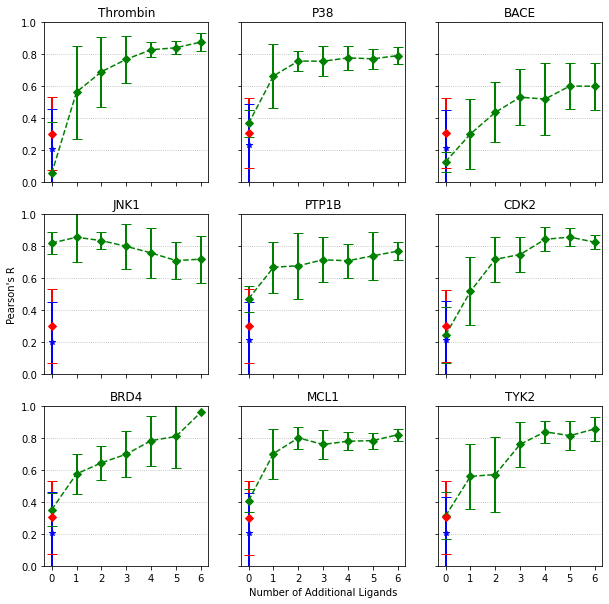

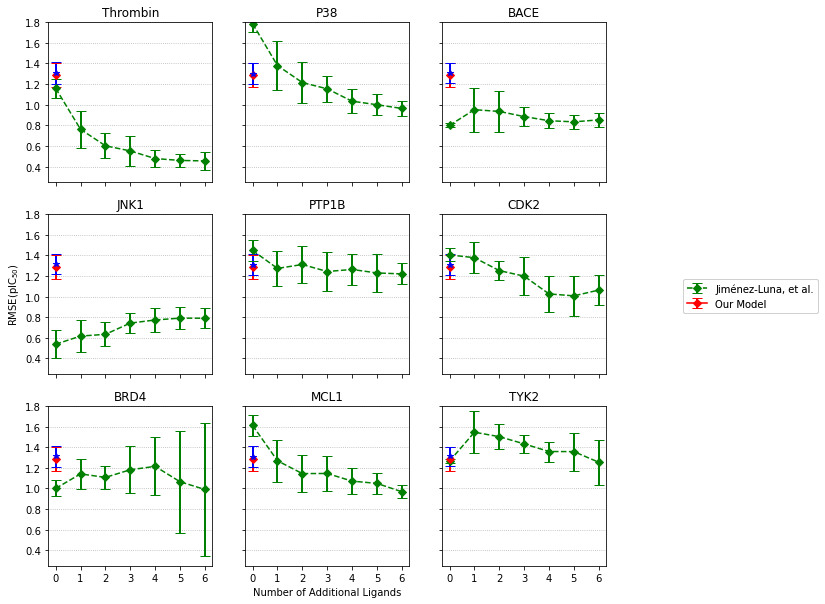

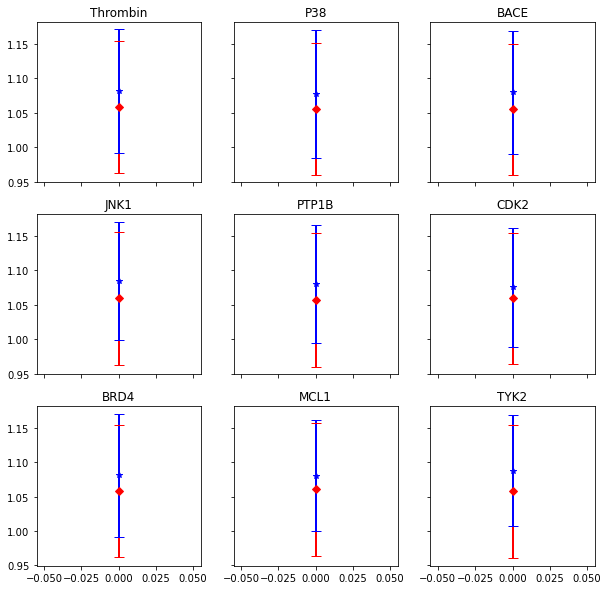

In [121]:
# external_ts = [ext_set.split('/')[-2] for ext_set in sorted(glob('external_test/*/'))]
rfig, raxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
rmsefig, rmseaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
maefig, maeaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
for idx, test_set in enumerate(paper_values.keys()):
    val = [idx // 3, idx % 3]
#     finetune_df = get_finetune(test_set)
    raxes[val[0],val[1]].set_title(test_set)
    theirs = raxes[val[0],val[1]].errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    def2018 = raxes[val[0],val[1]].errorbar(0,def2018_ft0[f'PearsonR_{test_set}'].mean(),yerr=def2018_ft0[f'PearsonR_{test_set}'].std(),label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    dense = raxes[val[0],val[1]].errorbar(0,dense_ft0[f'PearsonR_{test_set}'].mean(),yerr=dense_ft0[f'PearsonR_{test_set}'].std(),label='Our Model',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')

#     if finetune_df is not None:
#         raxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg R'],yerr=finetune_df['Stddev R'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
#         raxes[val[0],val[1]].plot([0,1],[float(final_data[f'{test_set}.Test R','mean']),float(finetune_df.loc['1','Avg R'])],c='r')
    if val[1] == 0 and val[0] == 1:
        raxes[val[0],val[1]].set_ylabel("Pearson's R")
    if val[0] == 2 and val[1] == 1:
        raxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
#     raxes[val[0],val[1]].legend()
#     ax = plt.gca()
    
    raxes[val[0],val[1]].set_ylim(bottom=0,top=1)
    raxes[val[0],val[1]].locator_params(axis='both',nbins=7)
    raxes[val[0],val[1]].grid(axis='y',linestyle=':')
#     if val[0] == 2 and val[1] == 2:
#         r_leg = rfig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))

    rmseaxes[val[0],val[1]].set_title(test_set)
    theirs= rmseaxes[val[0],val[1]].errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    def2018 = rmseaxes[val[0],val[1]].errorbar(0,def2018_ft0[f'RMSE_{test_set}'].mean(),yerr=def2018_ft0[f'RMSE_{test_set}'].std(),label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    dense = rmseaxes[val[0],val[1]].errorbar(0,dense_ft0[f'RMSE_{test_set}'].mean(),yerr=dense_ft0[f'RMSE_{test_set}'].std(),label='Our Model',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
#     if finetune_df is not None:
#         rmseaxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg RMSE'],yerr=finetune_df['Stddev RMSE'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
#         rmseaxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test RMSE','mean']),float(finetune_df.loc['1','Avg RMSE'])],c='r')
    if val[0] == 2 and val[1] == 1:
        rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    if val[1] == 0 and val[0] == 1:
        rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
    if val[0] == 2 and val[1] == 2:
        rmse_leg = rmsefig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
    rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
    rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
    rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
    
    maeaxes[val[0],val[1]].set_title(test_set)
    def2018 = maeaxes[val[0],val[1]].errorbar(0,def2018_ft0[f'MAE_{test_set}'].mean(),yerr=def2018_ft0[f'MAE_{test_set}'].std(),label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    dense = maeaxes[val[0],val[1]].errorbar(0,dense_ft0[f'MAE_{test_set}'].mean(),yerr=dense_ft0[f'MAE_{test_set}'].std(),label='Our Model',c='b',markeredgewidth=1,capsize=5,elinewidth=2,marker='*')
#     if finetune_df is not None:
#         rmseaxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg RMSE'],yerr=finetune_df['Stddev RMSE'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
#         rmseaxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test RMSE','mean']),float(finetune_df.loc['1','Avg RMSE'])],c='r')
    if val[0] == 2 and val[1] == 1:
        rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    if val[1] == 0 and val[0] == 1:
        rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
    if val[0] == 2 and val[1] == 2:
        rmse_leg = rmsefig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
    rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
    rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
    rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
# rfig.savefig('/home/drew/Presentations/Retreat_2021/figs/external_test_R.png',bbox_inches='tight',transparent=False)
# rmsefig.savefig('/home/drew/Presentations/Retreat_2021/figs/external_test_RMSE.png',bbox_inches='tight',transparent=False)

In [17]:
def get_paper_compare(use_model,dropout,strat_rec,finetune_fname):
    if dropout == 0:
        dropout = int(dropout)
    runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
             filters={"$and":[{"config.use_model":use_model},{'config.trainfile':'all_newdata.types'},
                             {"config.dropout":dropout},{"config.stratify_rec":strat_rec},{"config.eval":True},{"state":"finished"}]})
    our_data = pd.DataFrame(columns=external_dataset_measures)
    for run in runs:
    #     print(run)
        new_row = pd.DataFrame.from_dict(run.history(keys=external_dataset_measures,pandas=False)[0][0],orient='index').T
        our_data = our_data.append(new_row,ignore_index=True)
    final_data = pd.concat([our_data.mean(axis=0),our_data.std(axis=0)],axis=1)
    final_data.columns = ['mean','std']
    rfig, raxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
    rmsefig, rmseaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
    for idx, test_set in enumerate(paper_values.keys()):
        val = [idx // 3, idx % 3]
        finetune_df = get_finetune(test_set,finetune_fname)
        raxes[val[0],val[1]].set_title(test_set)
        theirs = raxes[val[0],val[1]].errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        ours = raxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test R','mean'],yerr=final_data.loc[f'{test_set}.Test R','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        if finetune_df is not None:
            raxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg R'],yerr=finetune_df['Stddev R'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
            raxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test R','mean']),float(finetune_df.loc['1','Avg R'])],c='r')
        if val[1] == 0 and val[0] == 1:
            raxes[val[0],val[1]].set_ylabel("Pearson's R")
        if val[0] == 2 and val[1] == 1:
            raxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    #     raxes[val[0],val[1]].legend()
    #     ax = plt.gca()

        raxes[val[0],val[1]].set_ylim(bottom=0,top=1)
        raxes[val[0],val[1]].locator_params(axis='both',nbins=7)
        raxes[val[0],val[1]].grid(axis='y',linestyle=':')
        if val[0] == 2 and val[1] == 2:
            r_leg = rfig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
        
        rmseaxes[val[0],val[1]].set_title(test_set)
        theirs= rmseaxes[val[0],val[1]].errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        ours = rmseaxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test RMSE','mean'],yerr=final_data.loc[f'{test_set}.Test RMSE','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        if finetune_df is not None:
            rmseaxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg RMSE'],yerr=finetune_df['Stddev RMSE'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
            rmseaxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test RMSE','mean']),float(finetune_df.loc['1','Avg RMSE'])],c='r')
        if val[0] == 2 and val[1] == 1:
            rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
        if val[1] == 0 and val[0] == 1:
            rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
        if val[0] == 2 and val[1] == 2:
            rmse_leg = rmsefig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
        rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
        rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
        rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
#     rfig.savefig('external_test/external_test_R.png',bbox_inches='tight',transparent=False)
#     rmsefig.savefig('external_test/external_test_RMSE.png',bbox_inches='tight',transparent=False)

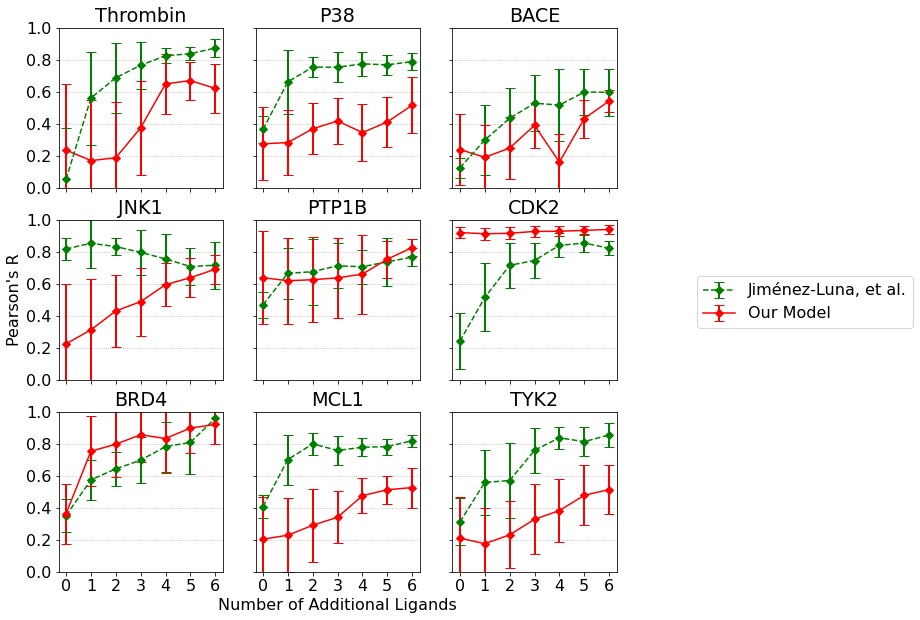

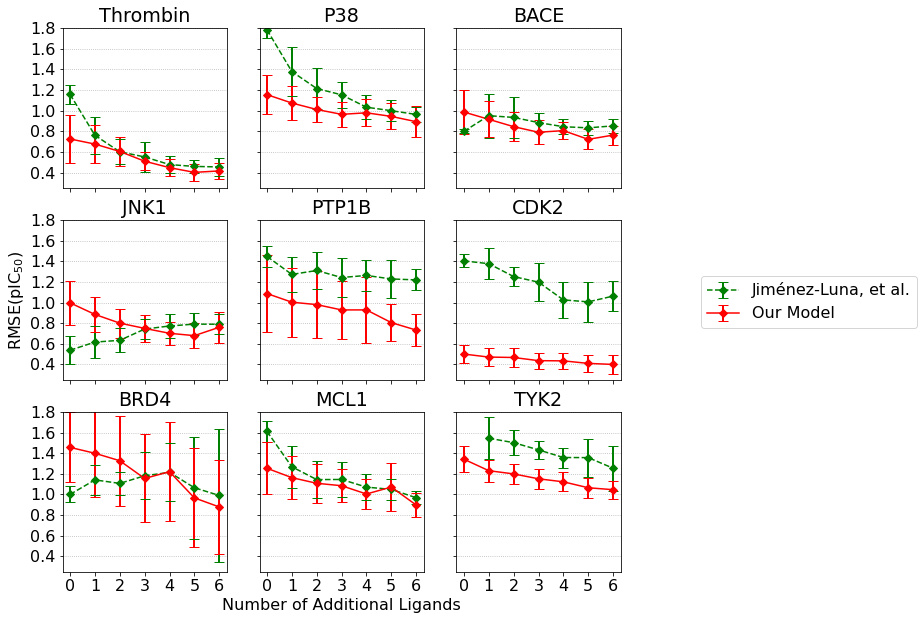

In [18]:
get_paper_compare('multtask_latent_def2018',0.5,False,'finetune_D5')

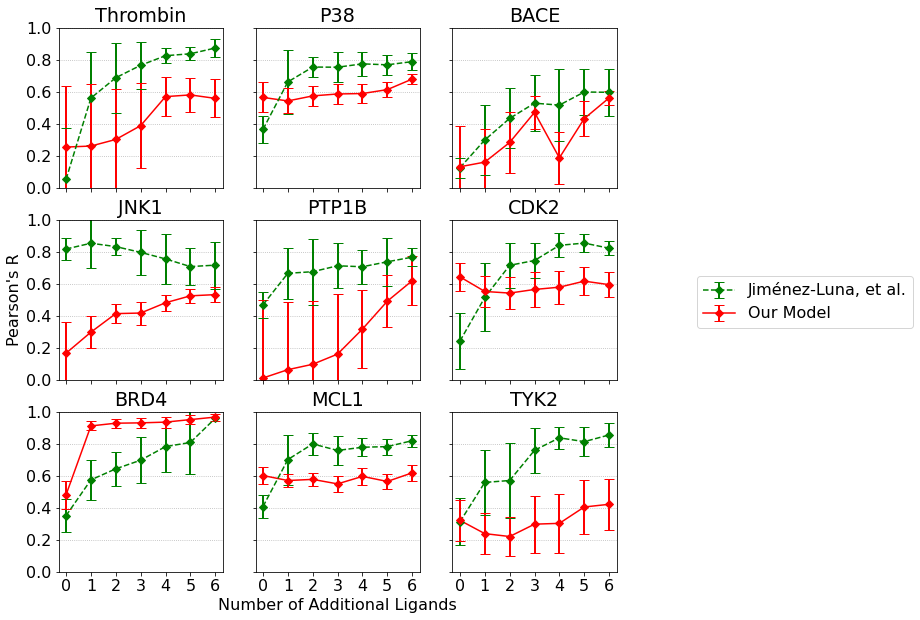

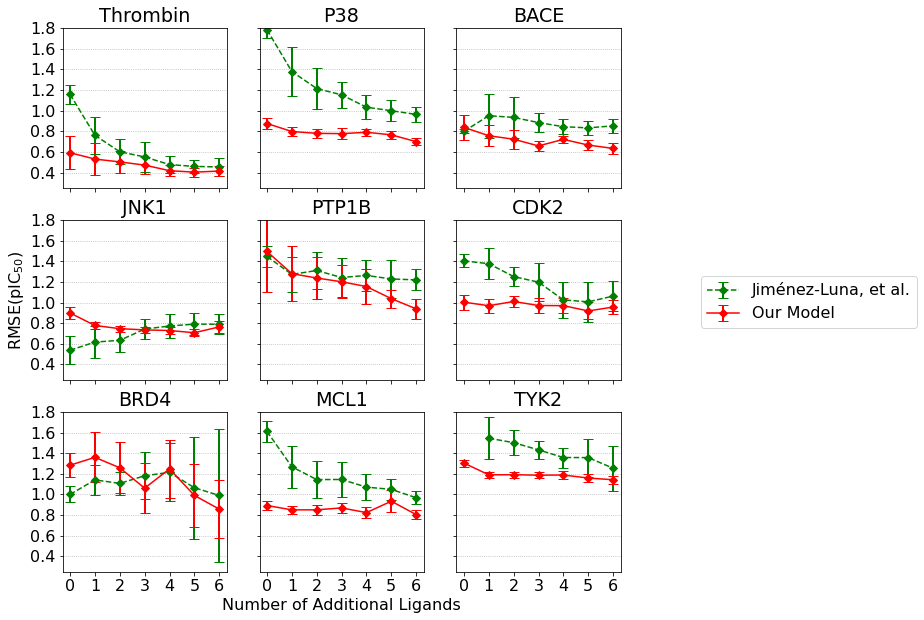

In [19]:
get_paper_compare('multtask_latent_def2018',0.5,True,'finetune_D5_SR')

/home/anm329/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


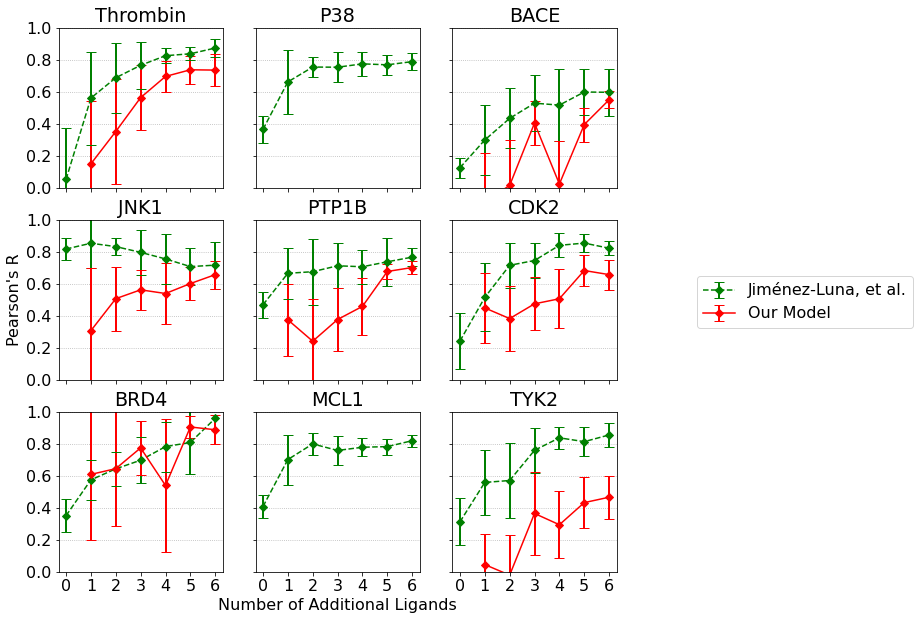

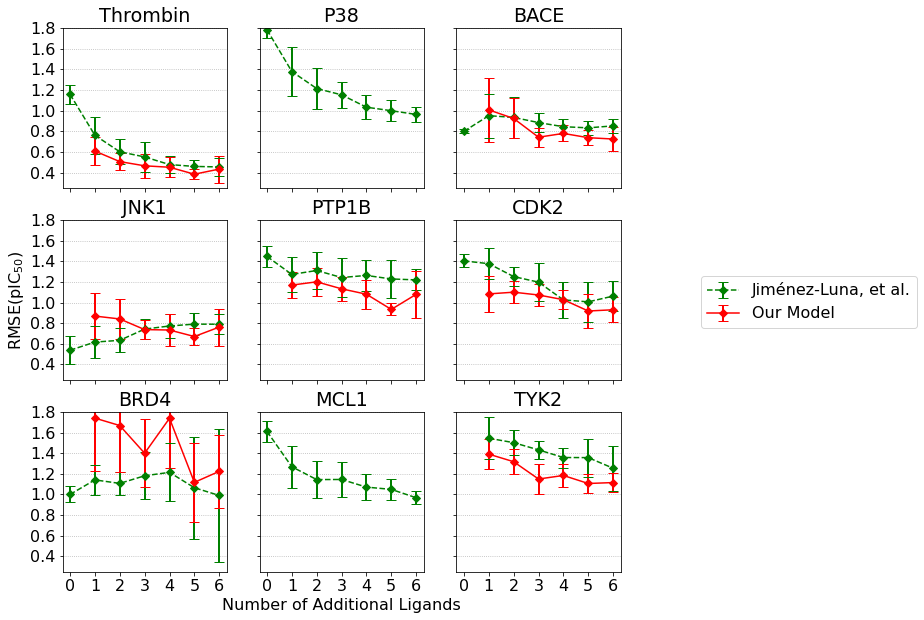

In [20]:
get_paper_compare('multtask_latent_def2018_concat',0,True,'finetune_concat_SR')